# Bayesian Dynamic TWFE

In [10]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
\begin{aligned}
Y_{it} = (\beta + r_{\beta}) * W_{it}  + \epsilon_{it} \\
\end{aligned}
$$

- $r_{\beta}$: 介入前後の経過時間

### ベイズモデル

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


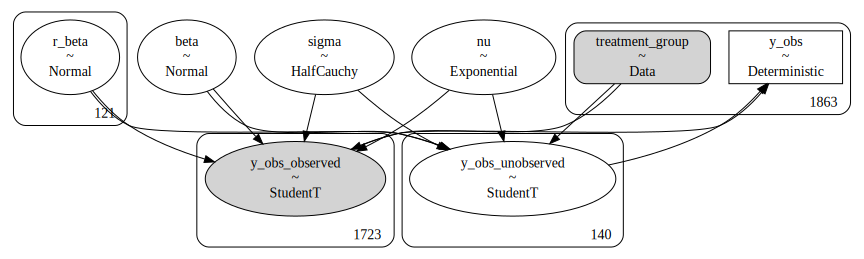

In [5]:
time_since_treatment, unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
len_unique_time_since_treatment = len(unique_time_since_treatment)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as dynamic_twfe:
    # data
    # treatment = pm.Data('treatment', df['after_treatment'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])

    # priors
    # random effect
    r_beta = pm.Normal('r_beta', mu=0, sigma=1, shape=len_unique_time_since_treatment)

    # fixed effect
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Exponential('nu', lam=1/5)

    # expectation
    mu = (beta + r_beta[time_since_treatment]) * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'])

pm.model_to_graphviz(dynamic_twfe)

In [6]:
with dynamic_twfe:
    trace_dynamic_twfe = pm.sample(
        draws=10000,
        tune=500,
        chains=4,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=123,
        target_accept=.9
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

  0%|          | 0/10500 [00:00<?, ?it/s]

Output()

In [7]:
az.summary(trace_dynamic_twfe, var_names=['beta', 'sigma', 'nu'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta  -0.023  0.095    -0.208      0.168      0.003    0.002     977.0   
sigma  0.144  0.005     0.135      0.154      0.000    0.000   24314.0   
nu     2.828  0.232     2.393      3.290      0.002    0.001   18055.0   

       ess_tail  r_hat  
beta     1908.0   1.01  
sigma   28685.0   1.00  
nu      26077.0   1.00

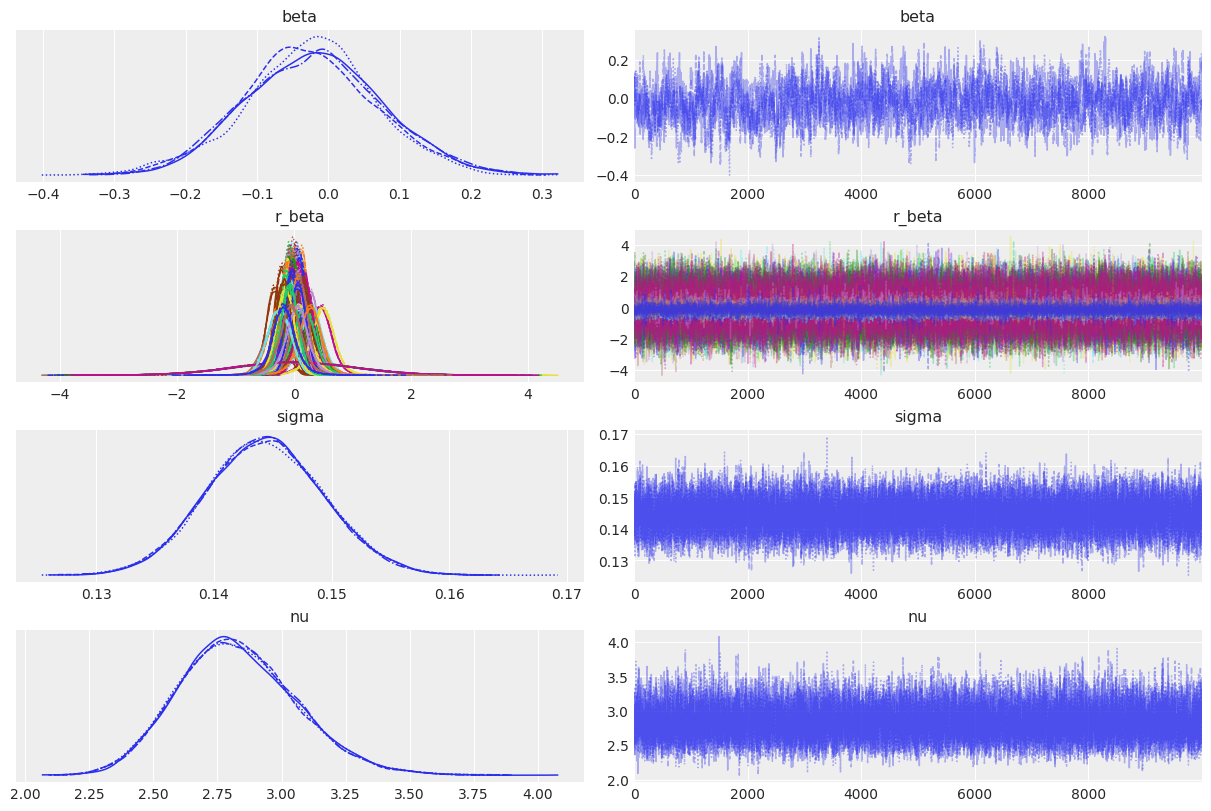

In [8]:
az.plot_trace(trace_dynamic_twfe, var_names=['beta', 'r_beta', 'sigma', 'nu']);

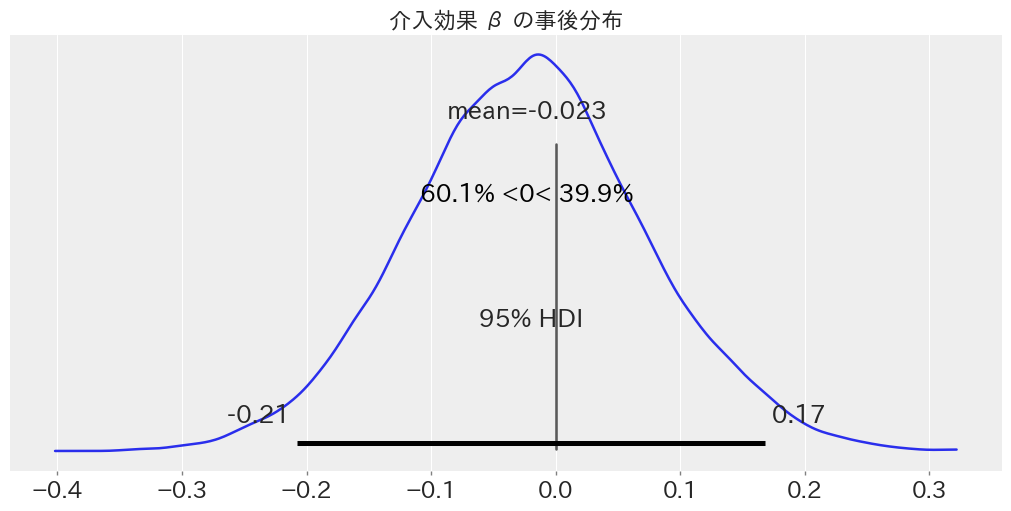

In [11]:
az.plot_posterior(trace_dynamic_twfe, var_names=['beta'], hdi_prob=0.95, ref_val=0, ref_val_color='k', figsize=(10 ,5));
plt.title('介入効果 β の事後分布');

In [13]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   165.54    44.13
p_waic      127.08        -

There has been a warning during the calculation. Please check the results.

In [14]:
# 数値を抽出する関数
def extract_number(text):
    match = re.search(r'\[-?\d+\]', text)
    if match:
        return int(match.group(0).strip('[]'))
    return None

def get_beta_df(trace):
    # ランダム効果のサマリーを取得
    beta_df = az.summary(trace, var_names=['r_beta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    # time_since_treatment_df = pd.DataFrame(unique_time_since_treatment, columns=['time_since_treatment_str'])
    # time_since_treatment_df['time_since_treatment'] = time_since_treatment_df['time_since_treatment_str'].apply(extract_number)

    # ランダム効果の値を経過年数と結合
    # ランダム効果の順番は経過年数の昇順ではなく，データに登場した順番になっている．
    # beta_df.reset_index(drop=True, inplace=True)
    # beta_df = pd.concat([beta_df, time_since_treatment_df], axis=1)
    beta_df['time_since_treatment'] = unique_time_since_treatment
    beta_df = beta_df.sort_values('time_since_treatment')

    # 新しい列に数値を格納

    return beta_df

def plot_effects_over_time(beta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_treatment',
        y='mean',
        data=beta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    # plt.errorbar(
    #     x=beta_df['time_since_treatment'],
    #     y=beta_df['mean'],
    #     yerr=[
    #         beta_df['mean'] - beta_df['hdi_2.5%'],
    #         beta_df['hdi_97.5%'] - beta_df['mean']
    #     ],
    #     fmt='o',
    #     color='black',
    #     alpha=0.5,
    #     capsize=5,
    #     label='95% HDI'
    # )
    plt.fill_between(
        x=beta_df['time_since_treatment'],
        y1=beta_df['hdi_97.5%'],
        y2=beta_df['hdi_2.5%'],
        color='black',
        alpha=0.2,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.ylim(-0.75, 0.75)
    plt.xlabel(r'\begin{CJK}{UTF8}{min}時間\end{CJK}')
    plt.ylabel(r'\begin{CJK}{UTF8}{min}$r_{\beta}$\end{CJK}')
    plt.title('Effects Over Time')
    plt.legend()
    # plt.show()

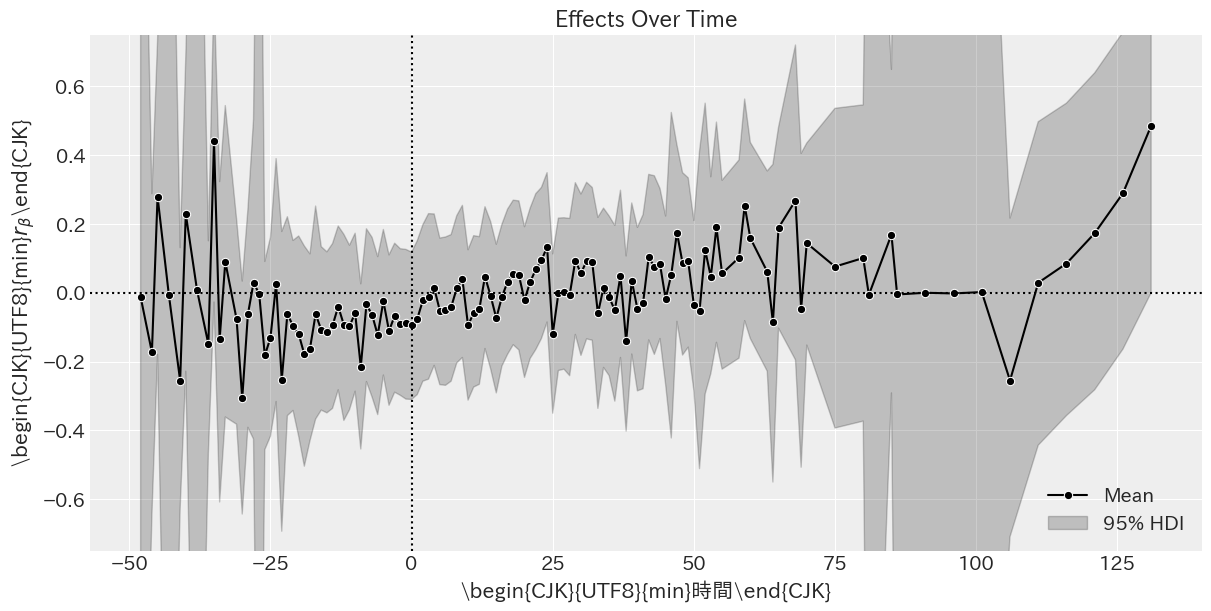

In [15]:
beta_df = get_beta_df(trace_dynamic_twfe)
plot_effects_over_time(beta_df)

## 階層ベイズモデル

In [143]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    # random effect
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfStudentT('sigma_alpha', nu=3, sigma=100)
    z_alpha = pm.Normal('z_alpha', mu=0, sigma=1, shape=len(df['island_ids'].unique()))
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * z_alpha)

    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfStudentT('sigma_lambda', nu=3, sigma=100)
    z_lambda = pm.Normal('z_lambda', mu=0, sigma=1, shape=len(df['years'].unique()))
    lambda_ = pm.Deterministic('lambda_', mu_lambda + sigma_lambda * z_lambda)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=100)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=100)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=len(df['time_since_intervention'].unique()))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + delta * treatment + gamma[time_since_intervention]*treatment_group + alpha[islands] + lambda_[years]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe_h)

KeyError: 'years'

In [16]:
with dynamic_twfe_h:
    trace_dynamic_twfe_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
az.summary(trace_dynamic_twfe_h, var_names=['intercept', 'delta', 'sigma'], hdi_prob=0.95)

mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
intercept   67.833  99.977  -128.967    257.804      7.789    5.518     165.0   
delta     -182.285  23.288  -227.173   -139.003      0.684    0.494    1188.0   
sigma       70.158   2.436    65.640     75.226      0.082    0.058     906.0   

           ess_tail  r_hat  
intercept     568.0   1.01  
delta        1529.0   1.00  
sigma        1434.0   1.01

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


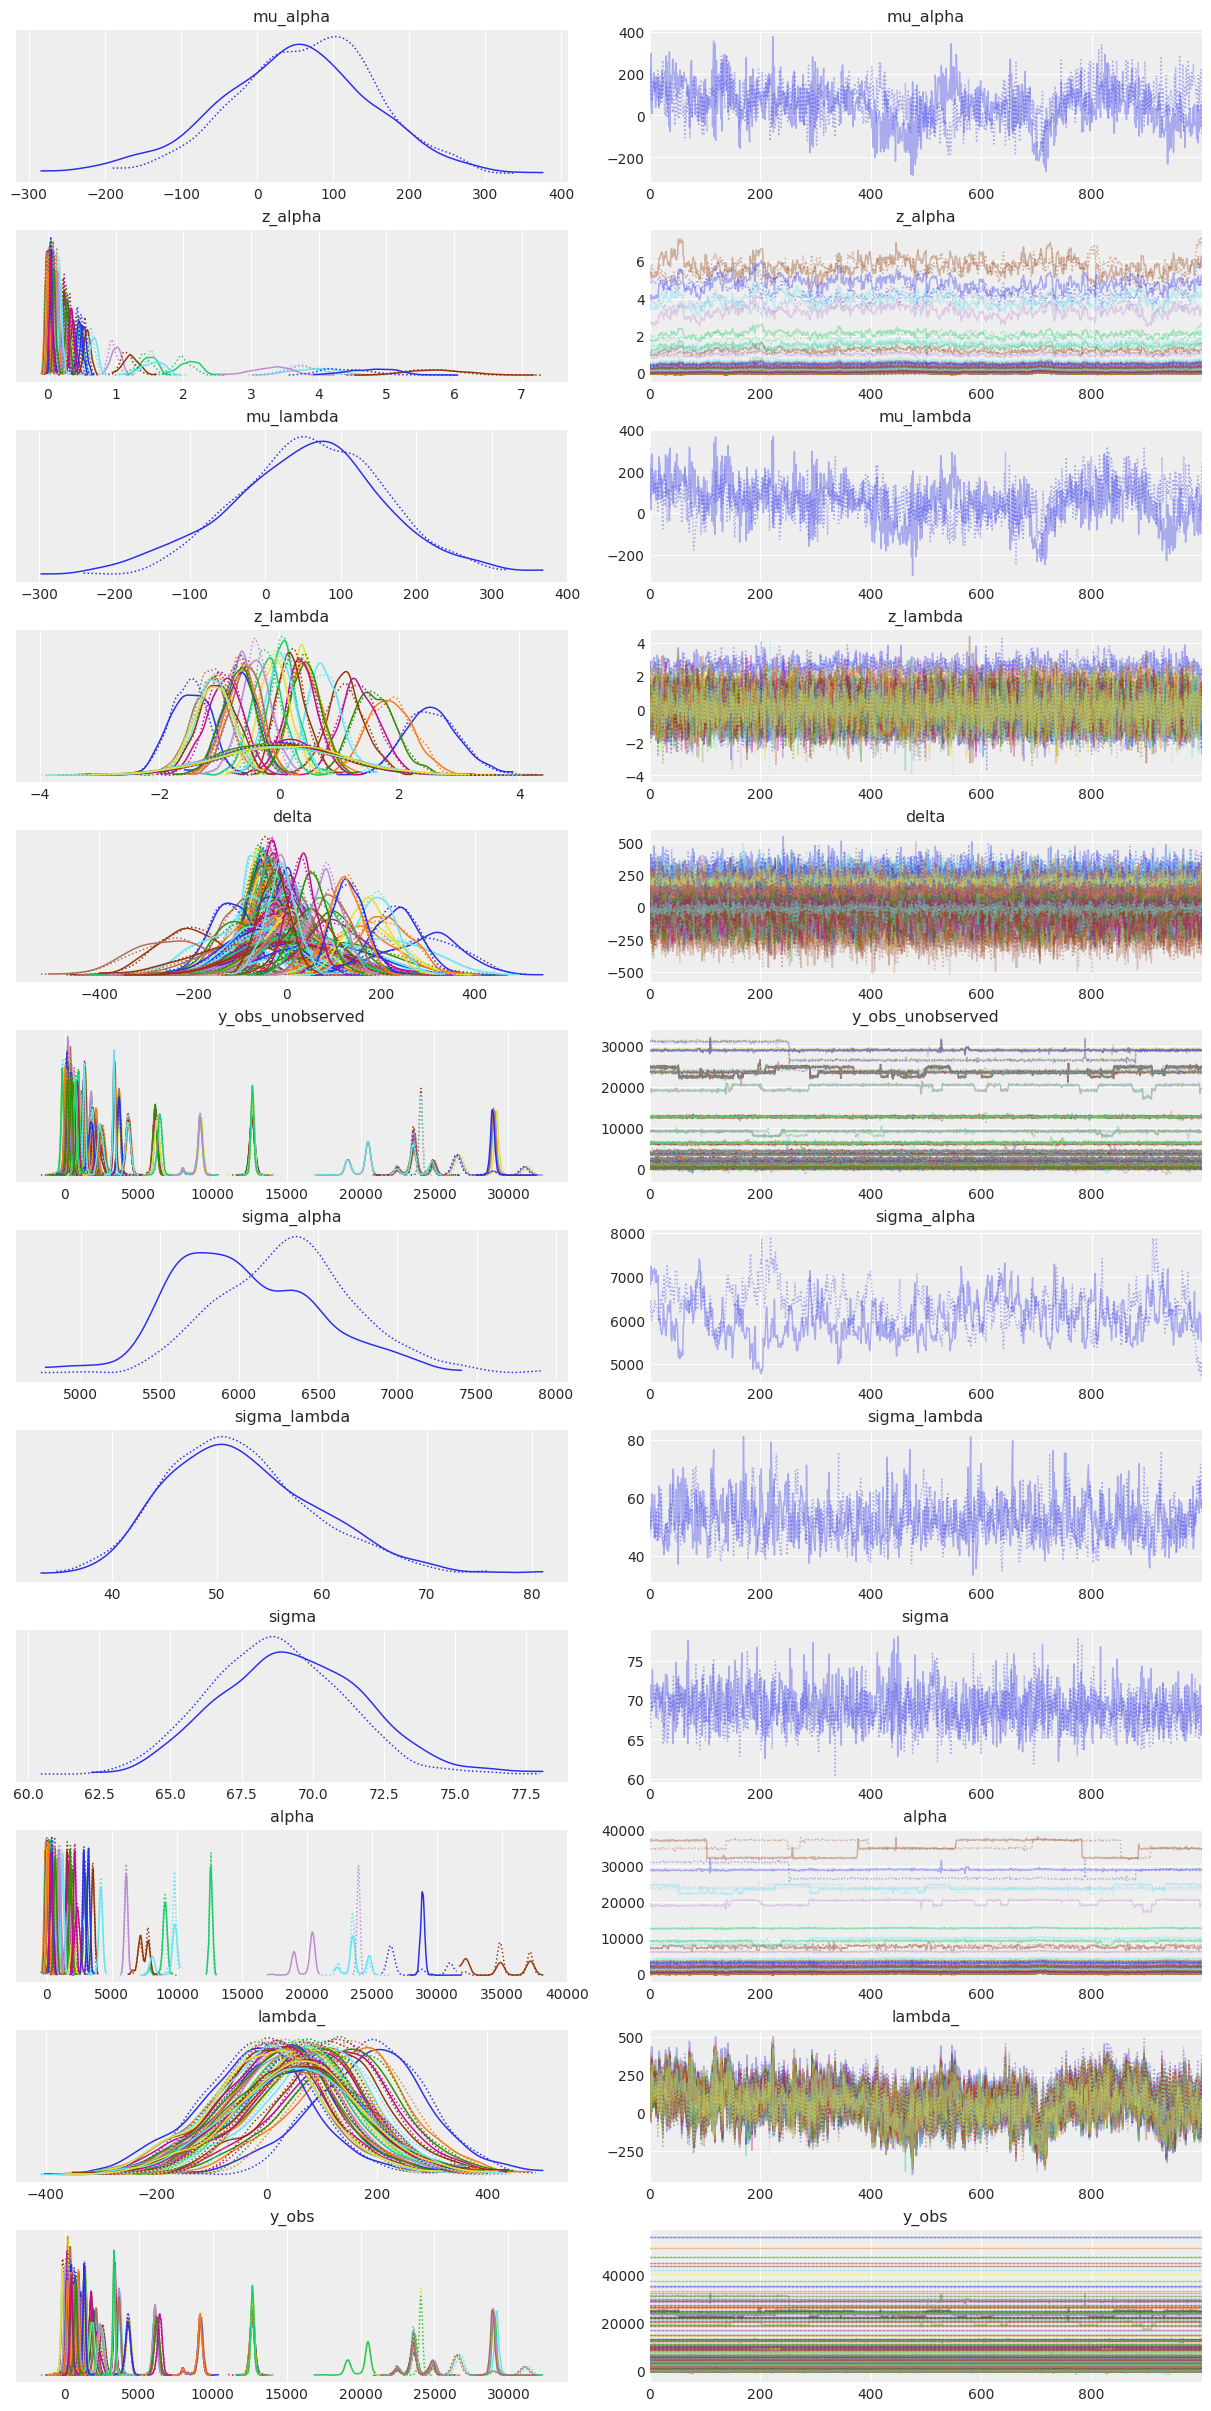

In [6]:
az.plot_trace(trace_dynamic_twfe_h);

In [18]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.waic(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -12113.89   188.72
p_waic      985.92        -

There has been a warning during the calculation. Please check the results.

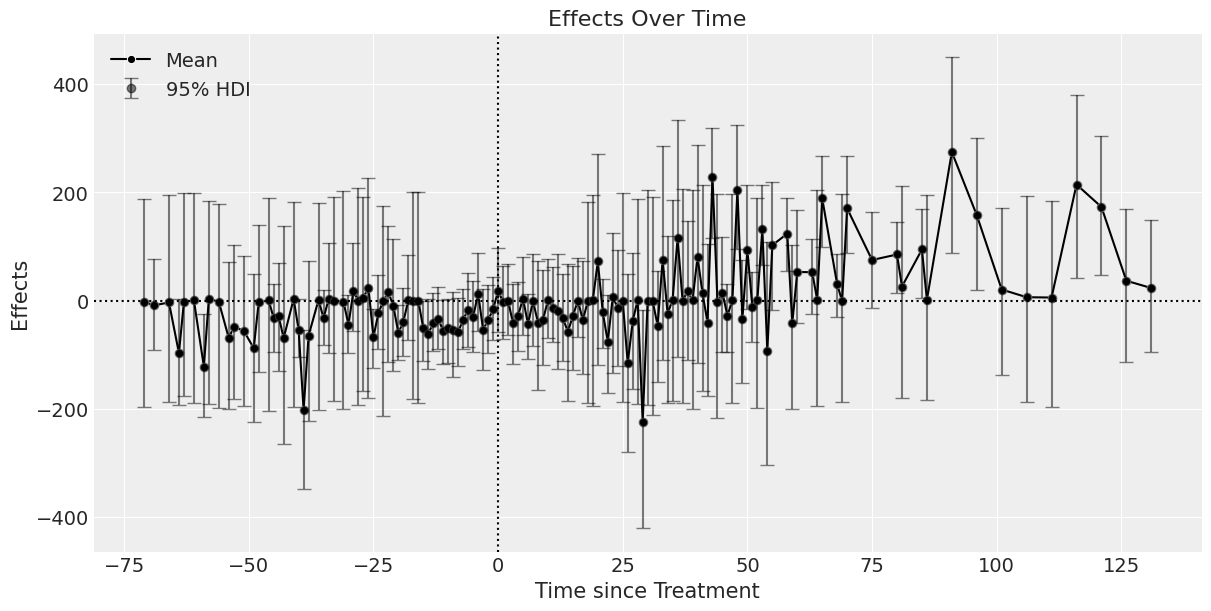

In [17]:
delta_df = get_delta_df(trace_dynamic_twfe_h)
plot_effects_over_time(delta_df)

## Bayesian Lasso

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


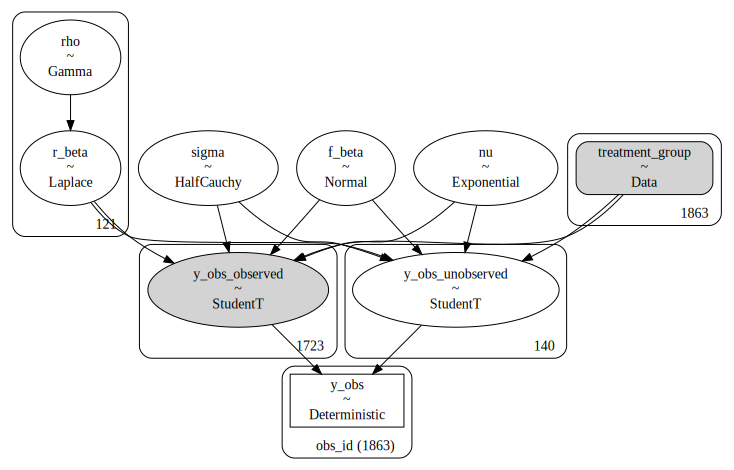

In [158]:
df['time_since_treatment'], unique_time_since_treatment = pd.factorize(df['time_since_treatment'])
time_since_treatment = df['time_since_treatment']
unique_time_since_treatment = time_since_treatment.unique()
len_unique_time_since_treatment = len(unique_time_since_treatment)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_lasso:
    # data
    # treatment = pm.Data('treatment', df['after_treatment'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])

    # priors
    # random effect
    rho = pm.Gamma('rho', alpha=1, beta=1, shape=len_unique_time_since_treatment)
    r_beta = pm.Laplace('r_beta', mu=0, b=1/rho**2, shape=len_unique_time_since_treatment)

    # fixed effect
    f_beta = pm.Normal('f_beta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)
    nu = pm.Exponential('nu', lam=1/30)

    # expectation
    # mu = pm.Deterministic('mu', (f_beta + r_beta[time_since_treatment]) * treatment_group)
    mu = (f_beta + r_beta[time_since_treatment]) * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_lasso)

In [173]:
with model_lasso:
    trace_lasso = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=6,
        # target_accept=0.9,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_lasso)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [174]:
### r_hat>1.1の確認
# 設定
idata_in = trace_lasso        # idata名
threshold = 1.1       # しきい値

# しきい値を超えるR_hatの個数を表示
print((az.rhat(idata_in) > threshold).sum())

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset> Size: 56B
Dimensions:           ()
Data variables:
    r_beta            int64 8B 24
    f_beta            int64 8B 1
    y_obs_unobserved  int64 8B 20
    rho               int64 8B 26
    sigma             int64 8B 0
    nu                int64 8B 0
    y_obs             int64 8B 20


In [175]:
az.summary(trace_lasso, var_names=['f_beta', 'sigma', 'nu'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
f_beta -0.040  0.017    -0.071     -0.005      0.003    0.002      41.0   
sigma   0.144  0.005     0.135      0.152      0.000    0.000     157.0   
nu      2.849  0.222     2.410      3.289      0.018    0.013     143.0   

        ess_tail  r_hat  
f_beta     206.0   1.11  
sigma      450.0   1.02  
nu         217.0   1.04

In [170]:
az.summary(trace_lasso, var_names=['r_beta'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
r_beta[0]   -0.028  0.096    -0.227      0.168      0.008    0.005     186.0   
r_beta[1]    0.031  0.120    -0.201      0.276      0.012    0.009      97.0   
r_beta[2]   -0.105  0.119    -0.356      0.113      0.010    0.008     150.0   
r_beta[3]   -0.056  0.068    -0.192      0.068      0.005    0.004     183.0   
r_beta[4]   -0.182  0.087    -0.350     -0.014      0.013    0.009      44.0   
...            ...    ...       ...        ...        ...      ...       ...   
r_beta[116] -0.081  0.114    -0.316      0.136      0.009    0.007     152.0   
r_beta[117] -0.055  0.103    -0.283      0.133      0.015    0.011      52.0   
r_beta[118]  0.036  0.159    -0.320      0.364      0.017    0.012     100.0   
r_beta[119] -0.035  0.132    -0.312      0.239      0.009    0.007     229.0   
r_beta[120] -0.089  0.151    -0.396      0.201      0.012    0.009     163.0   

             ess_tail  r_hat  
r_beta[0]       173.0   1.02  
r_beta[1]       235.0   1.04  
r_beta[2]       140.0   1.03  
r_beta[3]       385.0   1.01  
r_beta[4]       253.0   1.08  
...               ...    ...  
r_beta[116]     260.0   1.05  
r_beta[117]     140.0   1.07  
r_beta[118]     105.0   1.03  
r_beta[119]     250.0   1.02  
r_beta[120]     215.0   1.02  

[121 rows x 9 columns]

In [171]:
az.summary(trace_lasso, var_names=['rho'], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
rho[0]    2.472  1.414     0.225      5.185      0.096    0.068     191.0   
rho[1]    2.045  1.169     0.192      4.303      0.099    0.070     119.0   
rho[2]    2.013  1.160     0.279      4.264      0.080    0.057     184.0   
rho[3]    2.392  1.369     0.348      5.078      0.113    0.081     160.0   
rho[4]    1.740  0.894     0.178      3.367      0.064    0.045     173.0   
...         ...    ...       ...        ...        ...      ...       ...   
rho[116]  2.103  1.204     0.333      4.551      0.106    0.075     116.0   
rho[117]  1.971  1.096     0.365      4.179      0.088    0.062      98.0   
rho[118]  2.078  1.257     0.288      4.669      0.097    0.069     152.0   
rho[119]  2.108  1.198     0.210      4.443      0.073    0.052     229.0   
rho[120]  2.061  1.091     0.311      4.108      0.068    0.048     223.0   

          ess_tail  r_hat  
rho[0]       246.0   1.04  
rho[1]       192.0   1.04  
rho[2]       286.0   1.03  
rho[3]       324.0   1.02  
rho[4]       212.0   1.03  
...            ...    ...  
rho[116]     254.0   1.02  
rho[117]     225.0   1.04  
rho[118]     548.0   1.03  
rho[119]     329.0   1.04  
rho[120]     285.0   1.03  

[121 rows x 9 columns]

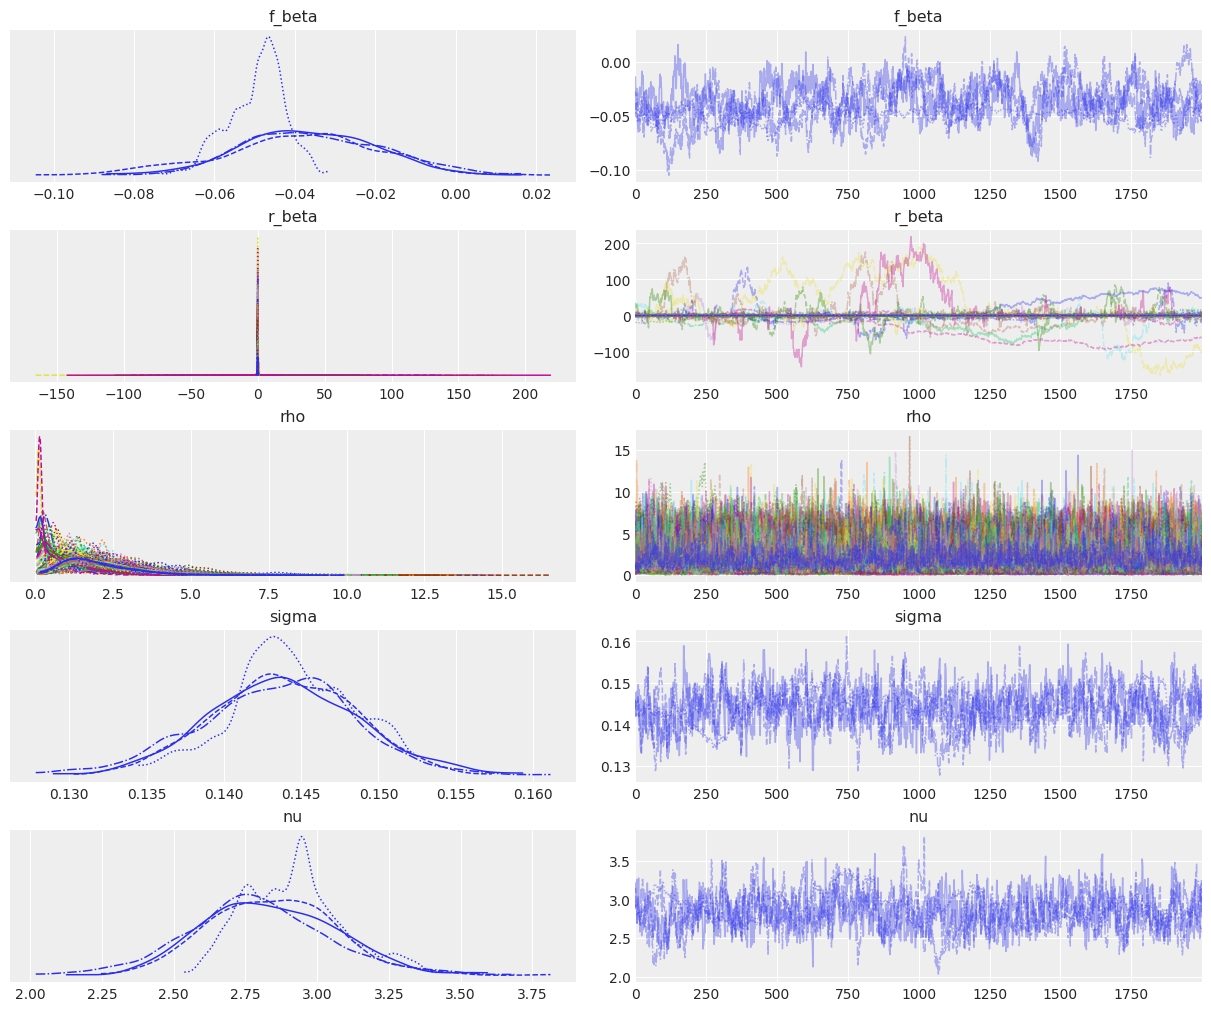

In [176]:
az.plot_trace(trace_lasso, var_names=['f_beta', 'r_beta', 'rho', 'sigma', 'nu']);

In [177]:
az.waic(trace_lasso)

/home/keisei/data-analysis/bridge-treatment-effects/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 1723 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   184.51    44.42
p_waic      107.04        -

There has been a warning during the calculation. Please check the results.

In [137]:
with model_lasso:
    pm.sample_posterior_predictive(trace_lasso, extend_inferencedata=True)

Sampling: [y_obs_observed]


Output()

(-1.0, 1.0)

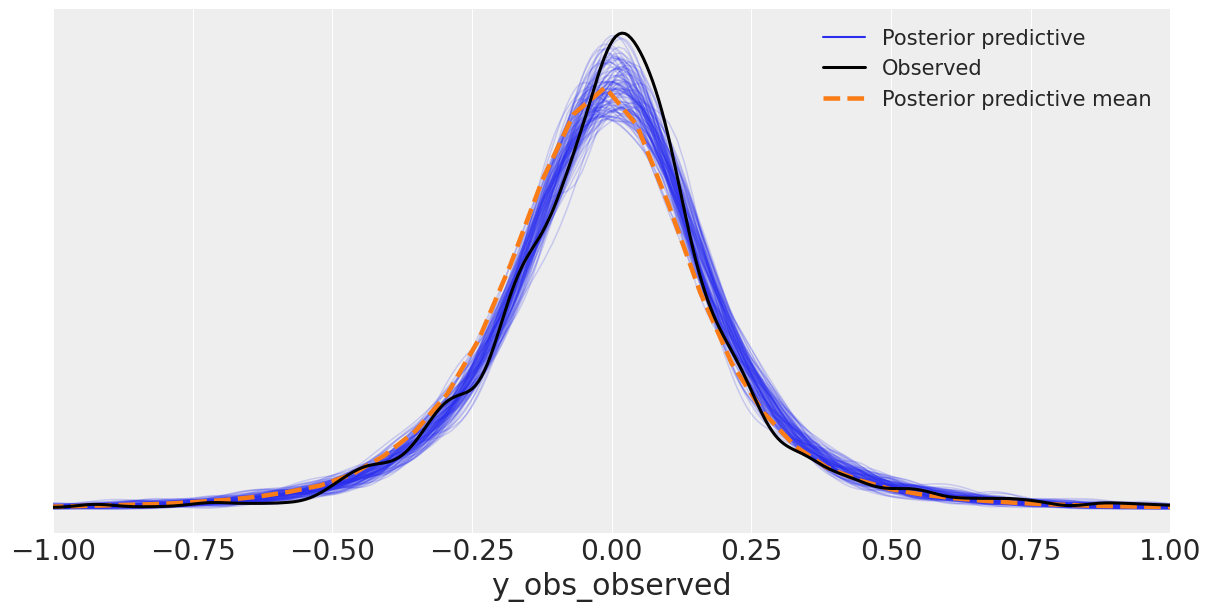

In [142]:
az.plot_ppc(trace_lasso, num_pp_samples=100, figsize=(12, 6))
plt.xlim(-1, 1)

In [126]:
df = pd.read_excel(filepath)
df['time_since_treatment'].nunique()

121

In [127]:
beta_df = az.summary(trace_lasso, var_names=['r_beta'], hdi_prob=0.95, kind='stats')
beta_df['time_since_treatment'] = df['time_since_treatment'].unique()
beta_df = beta_df.sort_values(by='time_since_treatment')

(-0.75, 0.75)

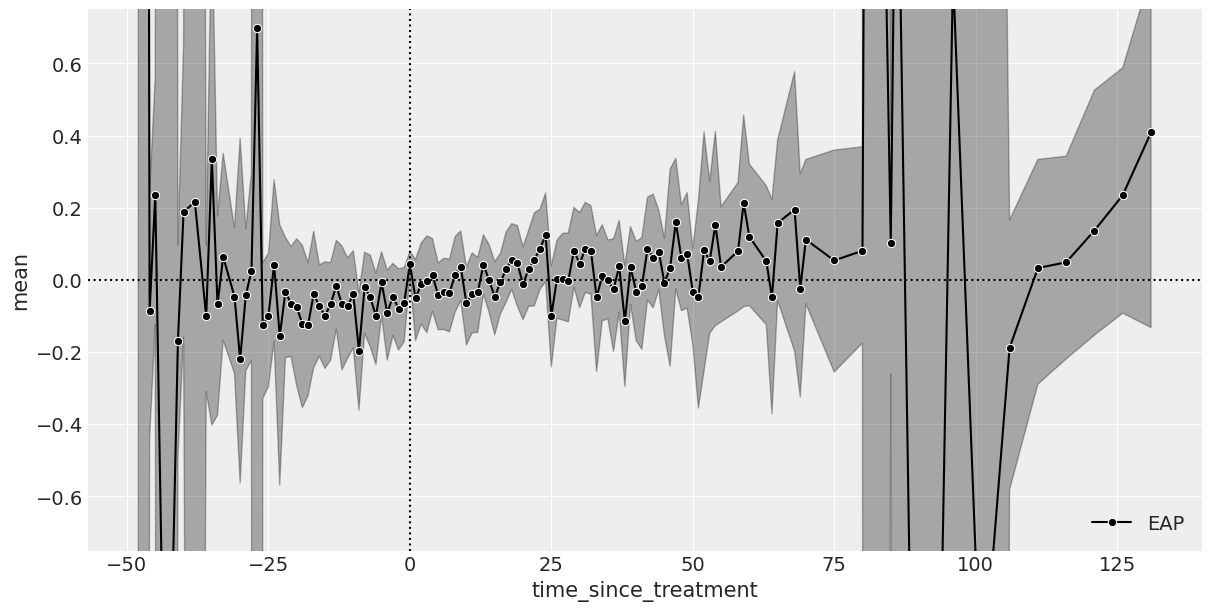

In [130]:
x = beta_df['time_since_treatment']
y = beta_df['mean']
y1 = beta_df['hdi_97.5%']
y2 = beta_df['hdi_2.5%']

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=x, y=y, ax=ax, color='black', marker='o', label='EAP')
ax.fill_between(x, y1, y2, color='black', alpha=0.3)
ax.axvline(x=0, color='black', linestyle=':')
ax.axhline(y=0, color='black', linestyle=':')
plt.ylim(-0.75, 0.75)


## サンプリングの保存

In [42]:
az.to_netcdf(trace_dynamic_twfe, './mcmc_sample/dynamic_twfe.nc')
# az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h.nc')

'./mcmc_sample/dynamic_twfe.nc'